In [1]:
#i use google colab and google drive so these first two cells are used for that porpuse

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
root = 'drive/MyDrive/colabs/7/data/'

In [3]:
import os
import tarfile
import torch
import numpy as np

import torchvision
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset

import torch.nn as nn
from torch.nn import AvgPool2d
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

!pip install torchsummary
from torchsummary import summary

from scipy.io import loadmat

from numpy import genfromtxt
import pandas as pd
import seaborn as sns

In [4]:

import os
import pandas as pd
import string

train_path = root + 'sign_mnist_train.csv'
test_path = root + 'sign_mnist_test.csv'
dataset = pd.read_csv(train_path)
testdataset = pd.read_csv(test_path)
num_rows = dataset.shape[0]
# To map each label number to its corresponding letter
letters = dict(enumerate(string.ascii_uppercase))

def dataframe_to_array(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1.iloc[:, 1:].to_numpy()
    targets_array = dataframe1['label'].to_numpy()
    return inputs_array, targets_array

inputs_array, targets_array = dataframe_to_array(dataset)
testinputs_array, testtargets_array = dataframe_to_array(testdataset)

print("Shape of train inputs:  {} ; Shape of train labels: {}".format(inputs_array.shape, targets_array.shape))
print("Shape of test inputs:  {} ; Shape of test labels: {}".format(testinputs_array.shape, testtargets_array.shape))

Shape of train inputs:  (27455, 784) ; Shape of train labels: (27455,)
Shape of test inputs:  (7172, 784) ; Shape of test labels: (7172,)


In [5]:
unique, counts = np.unique(targets_array, return_counts=True)
for i in range(9):
    print("{}: {}".format(letters[i],counts[i]))
for i in range(10,25):
    print("{}: {}".format(letters[i],counts[i-1]))

A: 1126
B: 1010
C: 1144
D: 1196
E: 957
F: 1204
G: 1090
H: 1013
I: 1162
K: 1114
L: 1241
M: 1055
N: 1151
O: 1196
P: 1088
Q: 1279
R: 1294
S: 1199
T: 1186
U: 1161
V: 1082
W: 1225
X: 1164
Y: 1118


Letter:  D
Letter:  G
Letter:  C
Letter:  C
Letter:  N


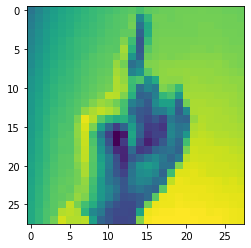

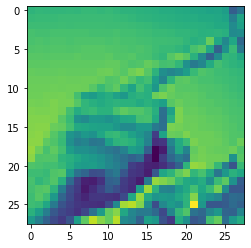

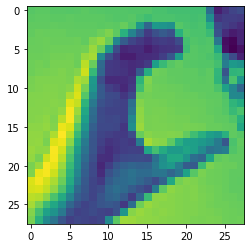

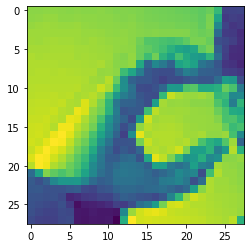

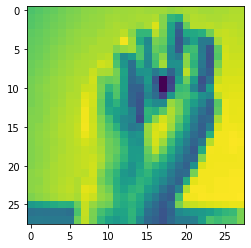

In [6]:
def show(image):
  ig, axes = plt.subplots()
  plt.imshow(image)
pic = []
for i in range(5):
    pic.append(np.reshape(inputs_array[i], (28, 28)))
    print("Letter: ", letters[targets_array[i].item()])
    show(pic[i])
 

Letter:  G
Letter:  F
Letter:  K
Letter:  A
Letter:  D


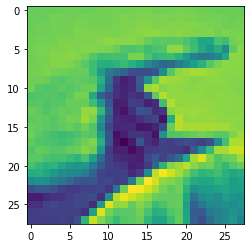

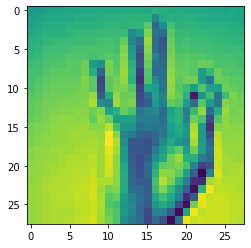

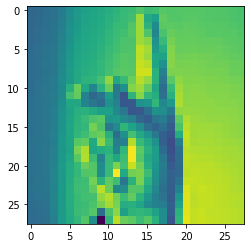

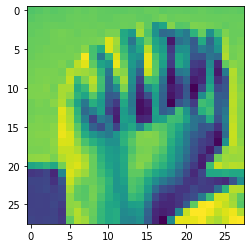

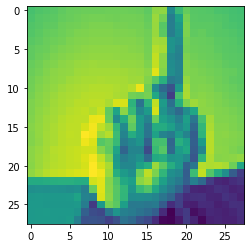

In [7]:
def show(image):
  ig, axes = plt.subplots()
  plt.imshow(image)
pic = []
for i in range(5):
    pic.append(np.reshape(testinputs_array[i], (28, 28)))
    print("Letter: ", letters[testtargets_array[i].item()])
    show(pic[i])
 

In [8]:
import random
#p is probability of a data participate as validation data set and 
#so 1- p is probability of a data participate as train data set 
p = 0.25

train_data = []
train_target = []
val_data = []
val_target = []

for i,j in zip(inputs_array, targets_array):
    p_hat = random.random()
    if p_hat > p:
        #normalize
        train_data.append(i/255)
        train_target.append(j)
    else:
        #normalize
        val_data.append(i/255)
        val_target.append(j)

train_data = np.array(train_data).reshape(-1,1,28,28)
train_target = np.array(train_target)
val_data = np.array(val_data).reshape(-1,1,28,28)
val_target = np.array(val_target)
testinputs_array = np.array(testinputs_array).reshape(-1,1,28,28)
testtargets_array = np.array(testtargets_array)

train_data = torch.from_numpy(train_data).float()
train_target = torch.from_numpy(train_target).long()
val_data = torch.from_numpy(val_data).float()
val_target = torch.from_numpy(val_target).long()
testinputs_array = torch.from_numpy(testinputs_array).float()
testtargets_array = torch.from_numpy(testtargets_array).long()

print("train data shape: ",train_data.shape)
print("train lables data shape: ",train_target.shape)
print("validation data shape: ",val_data.shape)
print("validation labels data shape: ",val_target.shape)
print("test data shape: ",testinputs_array.shape)
print("test labels data shape: ",testtargets_array.shape)

train data shape:  torch.Size([20668, 1, 28, 28])
train lables data shape:  torch.Size([20668])
validation data shape:  torch.Size([6787, 1, 28, 28])
validation labels data shape:  torch.Size([6787])
test data shape:  torch.Size([7172, 1, 28, 28])
test labels data shape:  torch.Size([7172])


In [ ]:
lr = 0.0001
input_size = 28*28
num_classes = 26
batch_size = 128
dropout1_rate = 0.3
dropout2_rate = 0.4


In [9]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(train_data, train_target)
val_dataset = TensorDataset(val_data, val_target)
test_dataset = TensorDataset(testinputs_array, testtargets_array)

# Dataloaders
train_dl = DataLoader(train_dataset, batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size)
test_dl = DataLoader(test_dataset, batch_size)

In [11]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            #nn.BatchNorm2d(16),

            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Dropout2d(dropout1_rate),
            
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(64),

            nn.Flatten(),
            nn.Linear(in_features=64*7*7, out_features=128),
            nn.Dropout(dropout2_rate),
            nn.Linear(in_features=128, out_features=26),

        )
        
    def forward(self, xb):
        return self.network(xb)
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
      print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
          epoch, result['train_loss'], result['val_loss'], result['val_acc']))
    
model = MnistModel()

In [12]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [13]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

In [14]:
evaluate(model, val_dl)

{'val_acc': 0.03226273134350777, 'val_loss': 3.3645129203796387}

In [15]:
history = fit(10, 1e-4, model, train_dl, val_dl,torch.optim.Adam)

Epoch [0], train_loss: 2.3387, val_loss: 1.4223, val_acc: 0.6030
Epoch [1], train_loss: 1.0036, val_loss: 0.7373, val_acc: 0.8012
Epoch [2], train_loss: 0.5536, val_loss: 0.4333, val_acc: 0.8900
Epoch [3], train_loss: 0.3351, val_loss: 0.2684, val_acc: 0.9434
Epoch [4], train_loss: 0.2095, val_loss: 0.1787, val_acc: 0.9701
Epoch [5], train_loss: 0.1389, val_loss: 0.1247, val_acc: 0.9796
Epoch [6], train_loss: 0.0974, val_loss: 0.0835, val_acc: 0.9929
Epoch [7], train_loss: 0.0694, val_loss: 0.0638, val_acc: 0.9928
Epoch [8], train_loss: 0.0522, val_loss: 0.0487, val_acc: 0.9967
Epoch [9], train_loss: 0.0413, val_loss: 0.0382, val_acc: 0.9970


Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

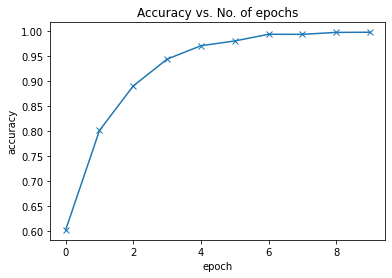

In [16]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')

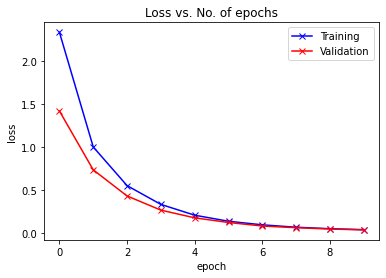

In [17]:
train_losses = [x.get('train_loss') for x in history]
val_losses = [x['val_loss'] for x in history]
plt.plot(train_losses, '-bx')
plt.plot(val_losses, '-rx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of epochs');

In [18]:
result = evaluate(model, test_dl)
result

{'val_acc': 0.7816612124443054, 'val_loss': 0.7027860879898071}

In [19]:
torch.save(model.state_dict(), 'signMnist_cnn.pth')

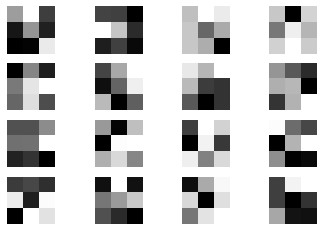

In [37]:
for j in model.parameters():
  for i, filter in enumerate(j):
      plt.subplot(4, 4, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
      plt.imshow(filter[0, :, :].detach(), cmap='gray')
      plt.axis('off')
  plt.show()
  break
